# **Credit Card Fraud Detection**

*Anonymized credit card transactions labeled as fraudulent or genuine.*

> [**Kaggle Dataset**](https://www.kaggle.com/mlg-ulb/creditcardfraud)

**References:**

*   [**Credit Card Fraud Classification using XGBOOST with OPTUNA**](https://www.kaggle.com/preatcher/credit-card-top-using-xgboost)

*   [**Credit Card Anomaly Detection - Auto Encoders**](https://www.kaggle.com/preatcher/credit-card-anamoly-encoder-decoder)


In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle datasets download -d mlg-ulb/creditcardfraud

In [ ]:
# Unzip Dataset.
!unzip creditcardfraud.zip

In [ ]:
# Import Library.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format="retina"
sns.set()
from warnings import filterwarnings

filterwarnings("ignore")

# Load Dataset.
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Dataset Shape.
print("The shape of the Dataset is", data.shape, "\n")

# Dataset Summary.
print(data.info())

In [ ]:
# Missing Values Count.
data.isnull().sum().max()

In [ ]:
# Statistics of "Amount" Class Frauds and Normal Transactions - Understanding the Normal vs. Fraud Transactions.
df_fraud = data[data["Class"] == 1]
df_normal = data[data["Class"] == 0]

print("Fraud Transaction Statistics:")
print(df_fraud["Amount"].describe())

print("\nNormal Transaction Statistics:")
print(df_normal["Amount"].describe())

Fraud Transaction Statistics:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal Transaction Statistics:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


***Outcome: Higher transactions are tending to be Fraud.***

In [ ]:
# Class Frequency of Dataset.
print(data["Class"].value_counts(), "\n")

# The classes are heavily skewed. We need to resolve this issue later.
print("No Frauds", round(data["Class"].value_counts()[0] / len(data) * 100, 2), "% of the dataset.")
print("Frauds", round(data["Class"].value_counts()[1] / len(data) * 100, 2), "% of the dataset.")

0    284315
1       492
Name: Class, dtype: int64 

No Frauds 99.83 % of the dataset.
Frauds 0.17 % of the dataset.


*Notice how imbalanced is the original dataset! Most of the transactions are in the Non-Fraud category. If we use this data as the base for our predictive models and analysis, we might get a lot of errors and our implemented ML algorithms will probably overfit since it will "assume" that most transactions are not a fraud. But we don't want our model to assume, instead it must accurately detect patterns that give signs of Fraud.*

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

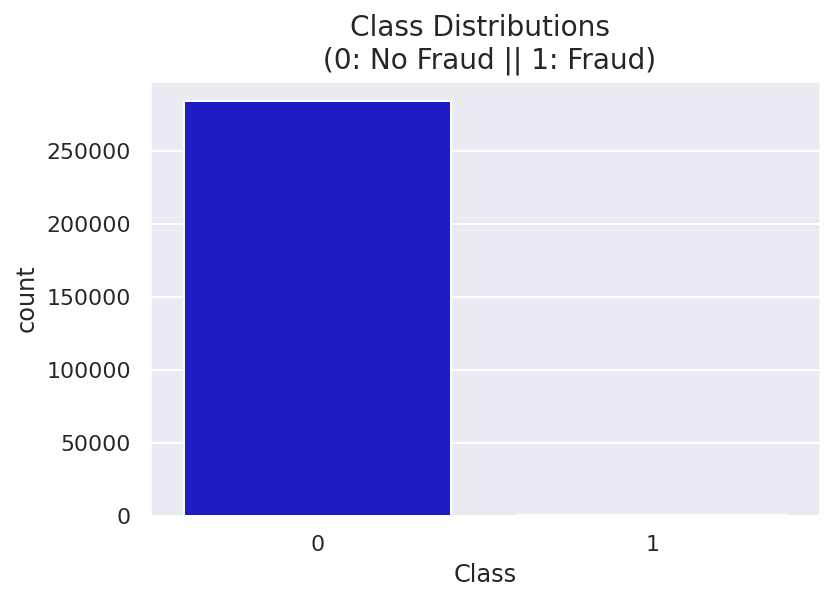

In [ ]:
# Plot Class Frequency.
colors = ["#0101DF", "#DF0101"]

sns.countplot("Class", data=data, palette=colors)
plt.title("Class Distributions \n (0: No Fraud || 1: Fraud)", fontsize=14)

***Distributions:*** *By seeing the distributions, we can have an idea of how skewed are these features. We can also see further distributions of the other features. There are techniques that can help the distributions be less skewed, which will be implemented in this notebook in the future.*

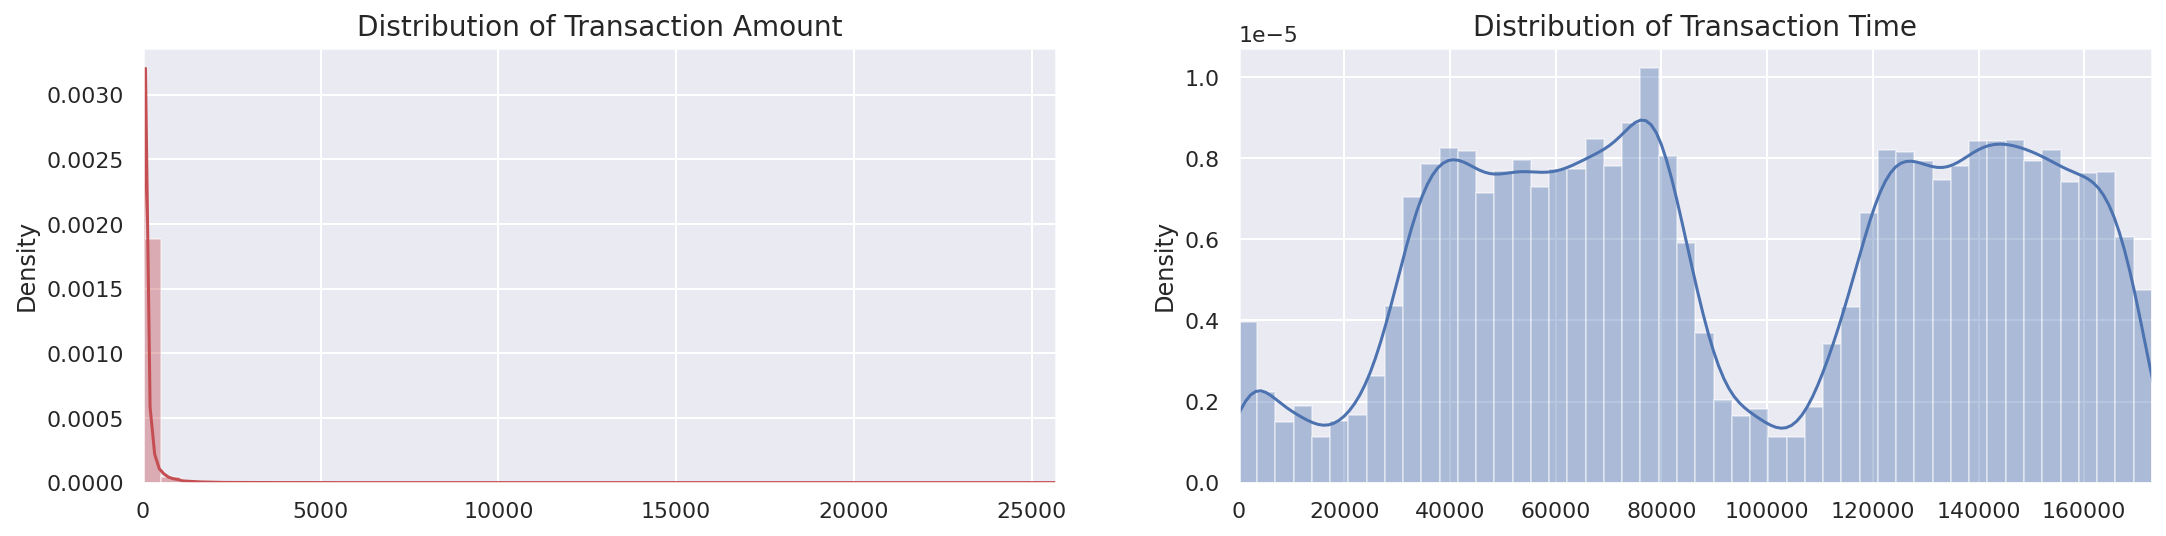

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
amount_val = data["Amount"].values
time_val = data["Time"].values
sns.distplot(amount_val, ax=ax[0], color="r")
ax[0].set_title("Distribution of Transaction Amount", fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
sns.distplot(time_val, ax=ax[1], color="b")
ax[1].set_title("Distribution of Transaction Time", fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

#### **Explore the distribution by Class types through Hours and Minutes.**

In [ ]:
timedelta = pd.to_timedelta(data["Time"], unit="s")
data["Time_min"] = (timedelta.dt.components.minutes).astype(int)
data["Time_hour"] = (timedelta.dt.components.hours).astype(int)

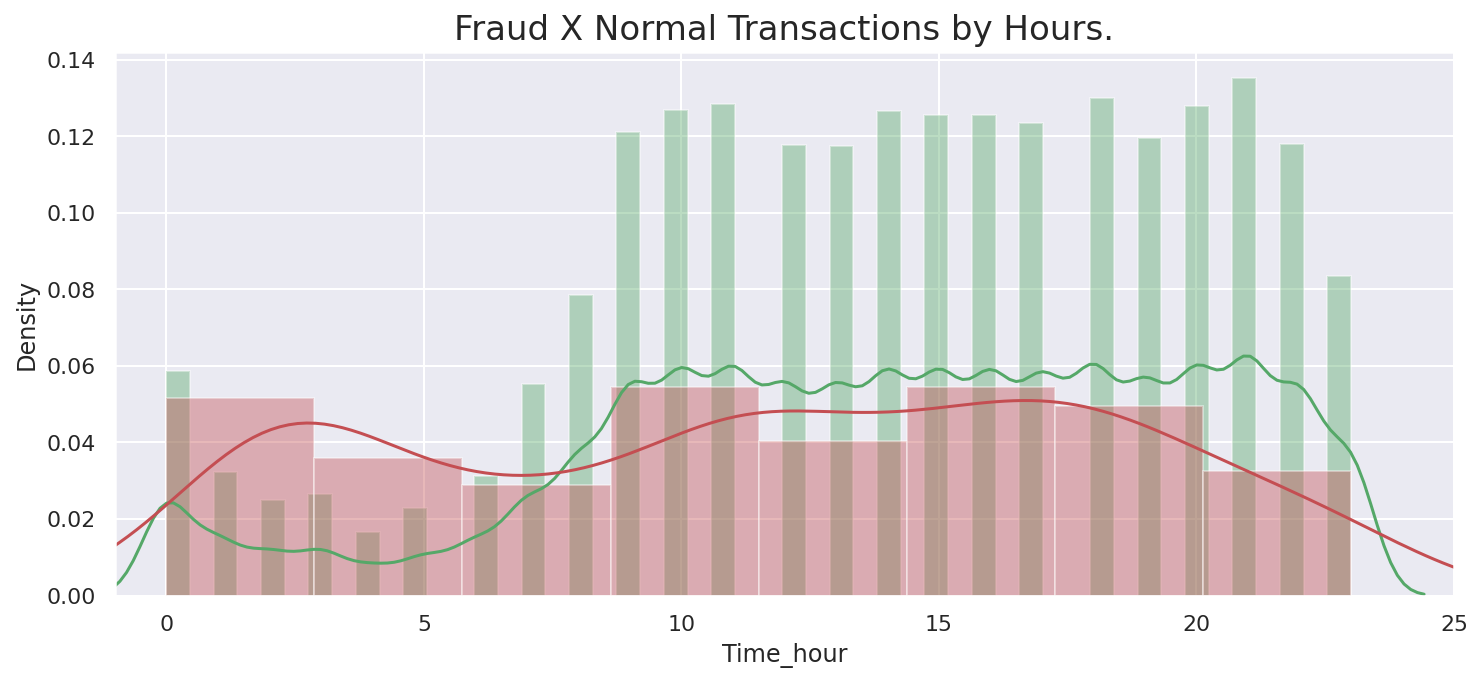

In [ ]:
plt.figure(figsize=(12, 5))
sns.distplot(data[data["Class"] == 0]["Time_hour"], color="g")
sns.distplot(data[data["Class"] == 1]["Time_hour"], color="r")
plt.title("Fraud X Normal Transactions by Hours.", fontsize=17)
plt.xlim([-1, 25])
plt.show()

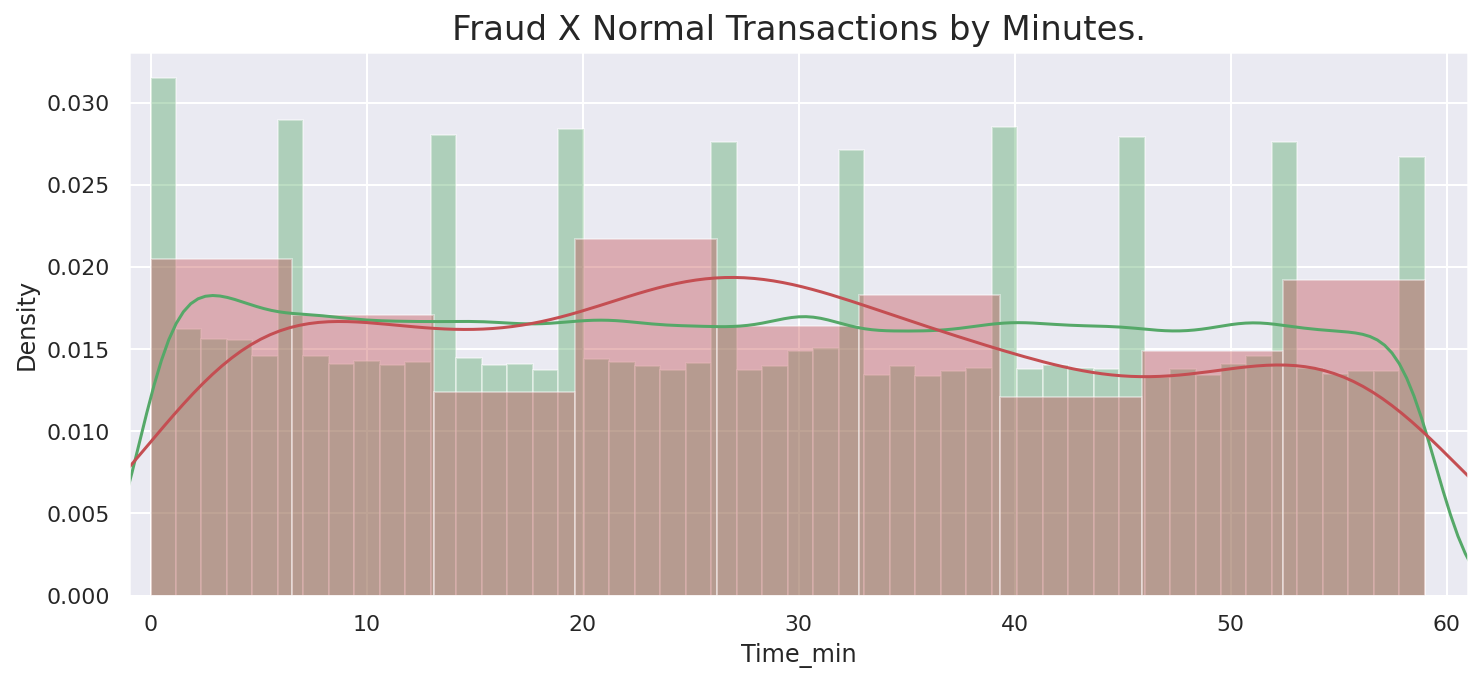

In [ ]:
plt.figure(figsize=(12, 5))
sns.distplot(data[data["Class"] == 0]["Time_min"], color="g")
sns.distplot(data[data["Class"] == 1]["Time_min"], color="r")
plt.title("Fraud X Normal Transactions by Minutes.", fontsize=17)
plt.xlim([-1, 61])
plt.show()

#### **Explore a Scatter Plot of Hours and Minutes by Amount.**

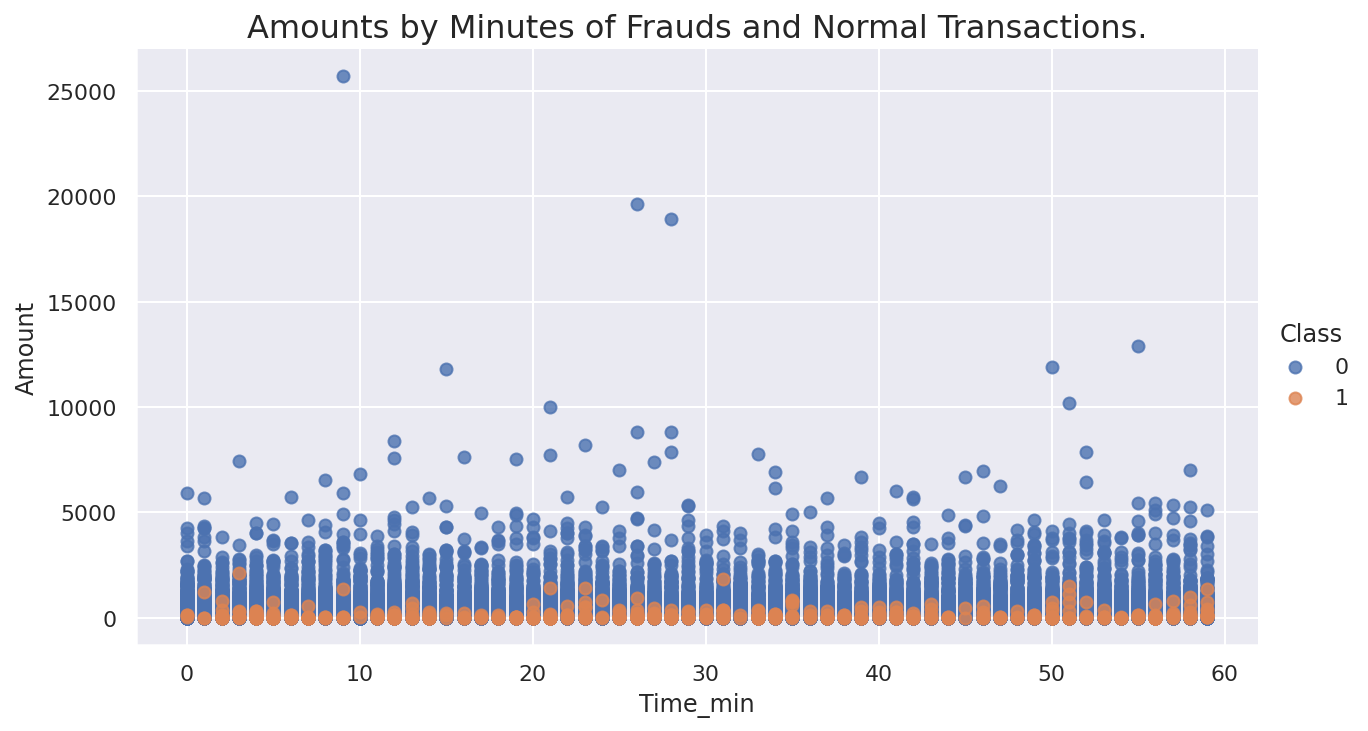

In [ ]:
# Explore the Amount and Time distribution of FRAUD transactions.
ax = sns.lmplot(y="Amount", x="Time_min", fit_reg=False, aspect=1.8, data=data, hue="Class")
plt.title("Amounts by Minutes of Frauds and Normal Transactions.", fontsize=16)
plt.show()

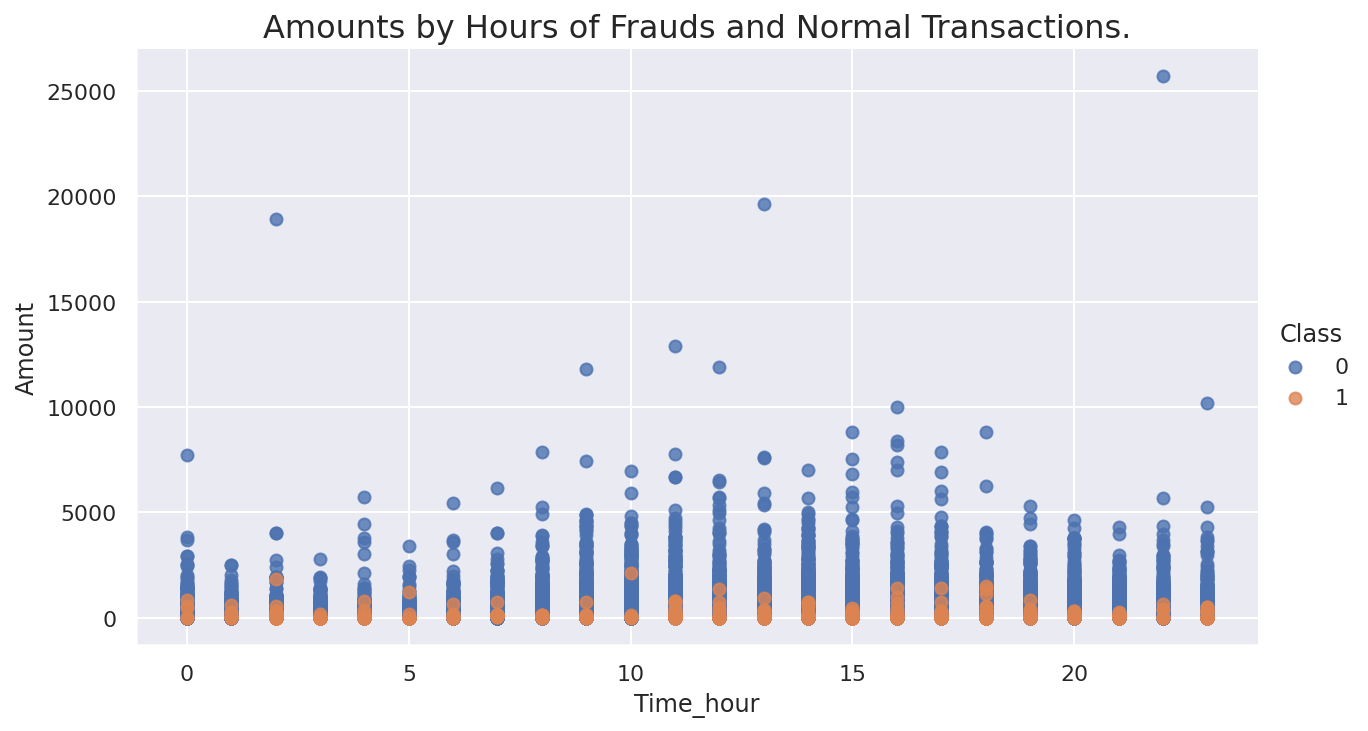

In [ ]:
ax = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False, aspect=1.8, data=data, hue="Class")
plt.title("Amounts by Hours of Frauds and Normal Transactions.", fontsize=16)
plt.show()

### **Feature Selection using Distribution Graph.**

The features that follow the same distribution for both legitimate and fraudulent transactions are not important features.

In the below graph, "**V15**", "**V17**", "**V22**", "**V24**", "**V25**", "**V26**", "**V27**", "**V28**", "**Time_min**", and "**Time_hour**" features have the same distributions for fraud and legitimate transactions. Therefore, these features are not important and should be removed.

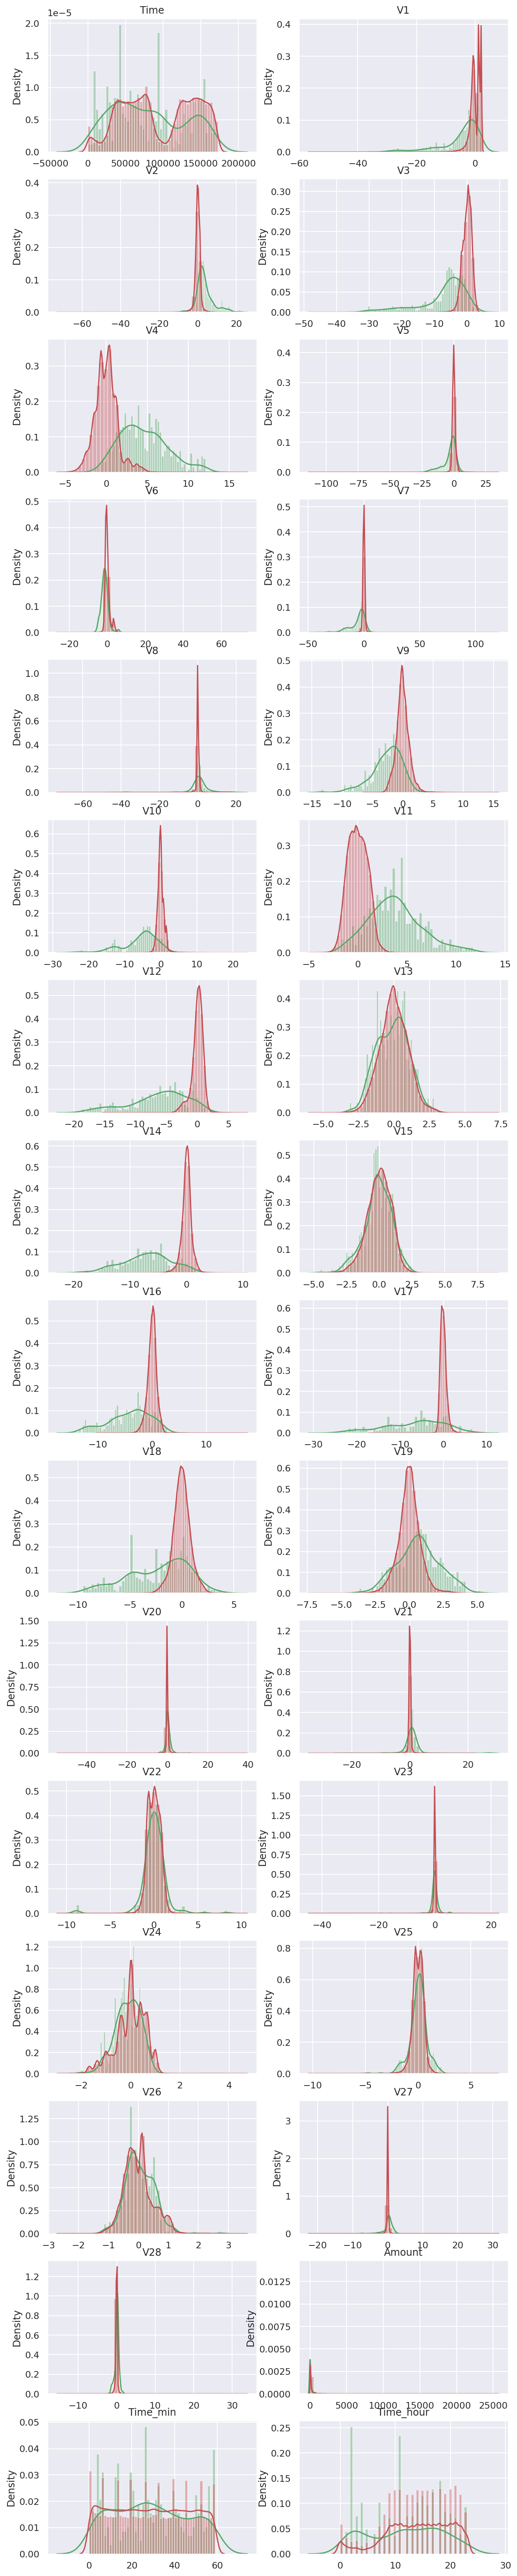

In [ ]:
# Distribution Graph Plot.
import matplotlib.gridspec as gridspec

columns = data.iloc[:, data.columns != "Class"].columns
frauds = data.Class == 1
normals = data.Class == 0
grid = gridspec.GridSpec(17, 2)
plt.figure(figsize=(10, 15 * 4))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(data[col][frauds], bins=50, color="g")
    sns.distplot(data[col][normals], bins=50, color="r")
    ax.set_ylabel("Density")
    ax.set_title(str(col))
    ax.set_xlabel("")
plt.show()

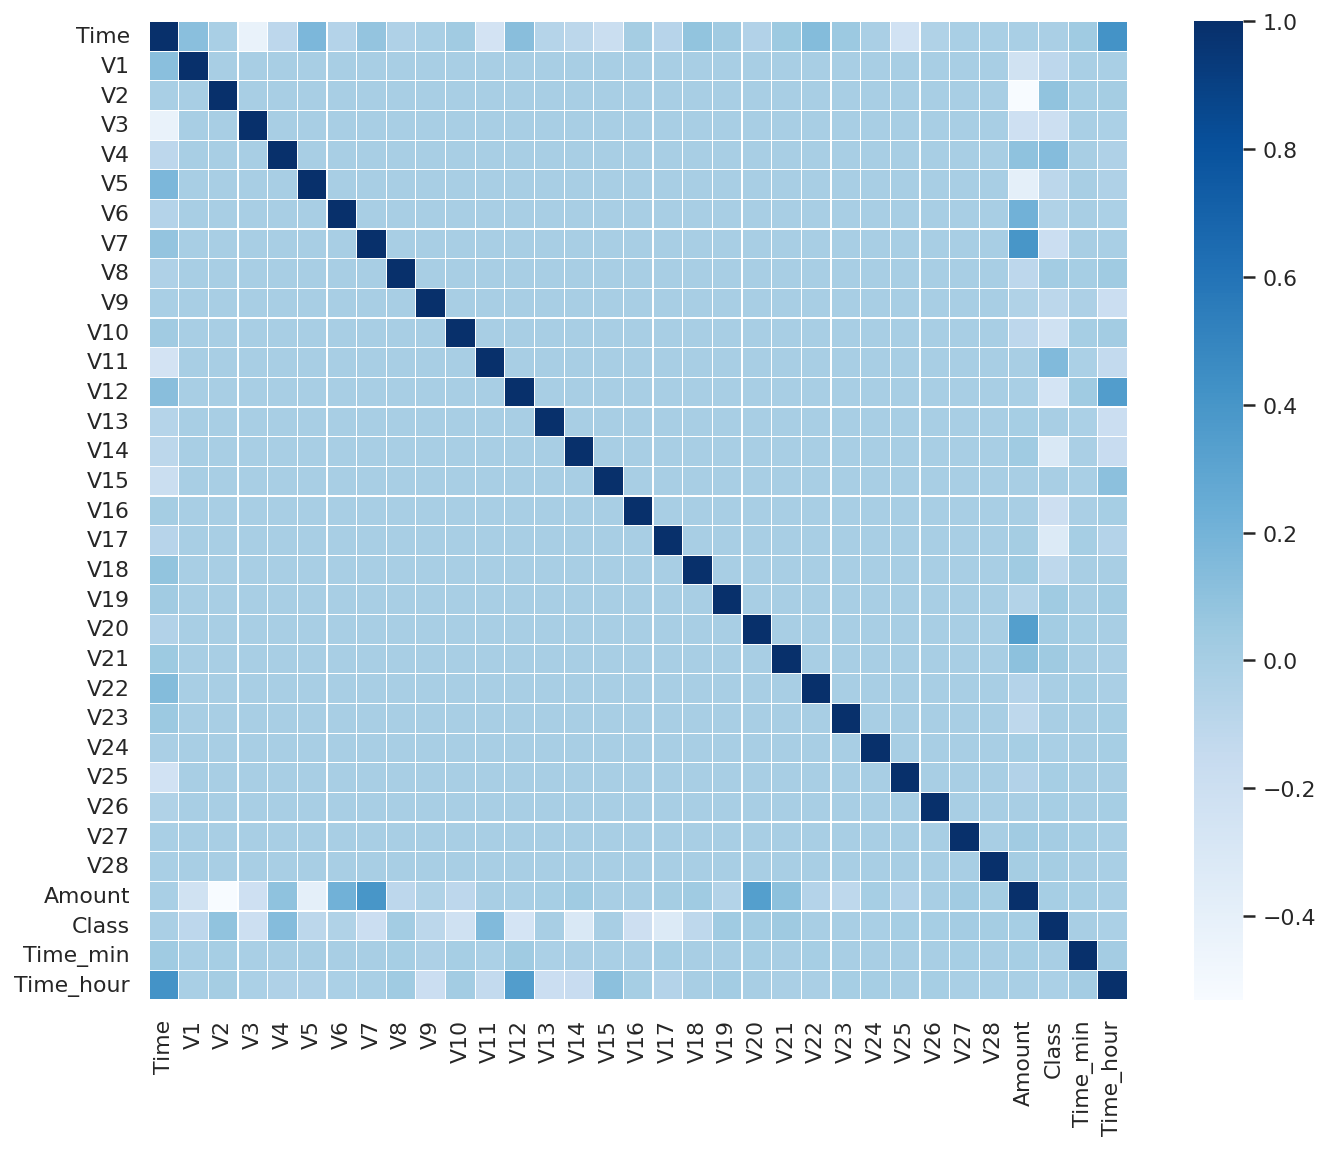

In [ ]:
# Correlation Plot.
colormap = plt.cm.Blues
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white")
plt.show()

## **Prepare the Dataset.**

In [ ]:
# Feature Selection.
data = data.copy()
data.drop(
    ["V15", "V17", "V22", "V24", "V25", "V26", "V27", "V28", "Time_hour", "Time_min"],
    axis=1,
    inplace=True,
)

# Split the dataset into Features and Target Set.
X = data.iloc[:, :-1]
y = data["Class"]

# Split the dataset into Training and Test Set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling - "Time" and "Amount" features should be scaled just like the other remaining features.
from sklearn.preprocessing import RobustScaler

rsc = RobustScaler()
X_train["Amount"] = rsc.fit_transform(X_train["Amount"].values.reshape(-1, 1))
X_train["Time"] = rsc.fit_transform(X_train["Time"].values.reshape(-1, 1))

## **Outlier Detection in Training Dataset.**

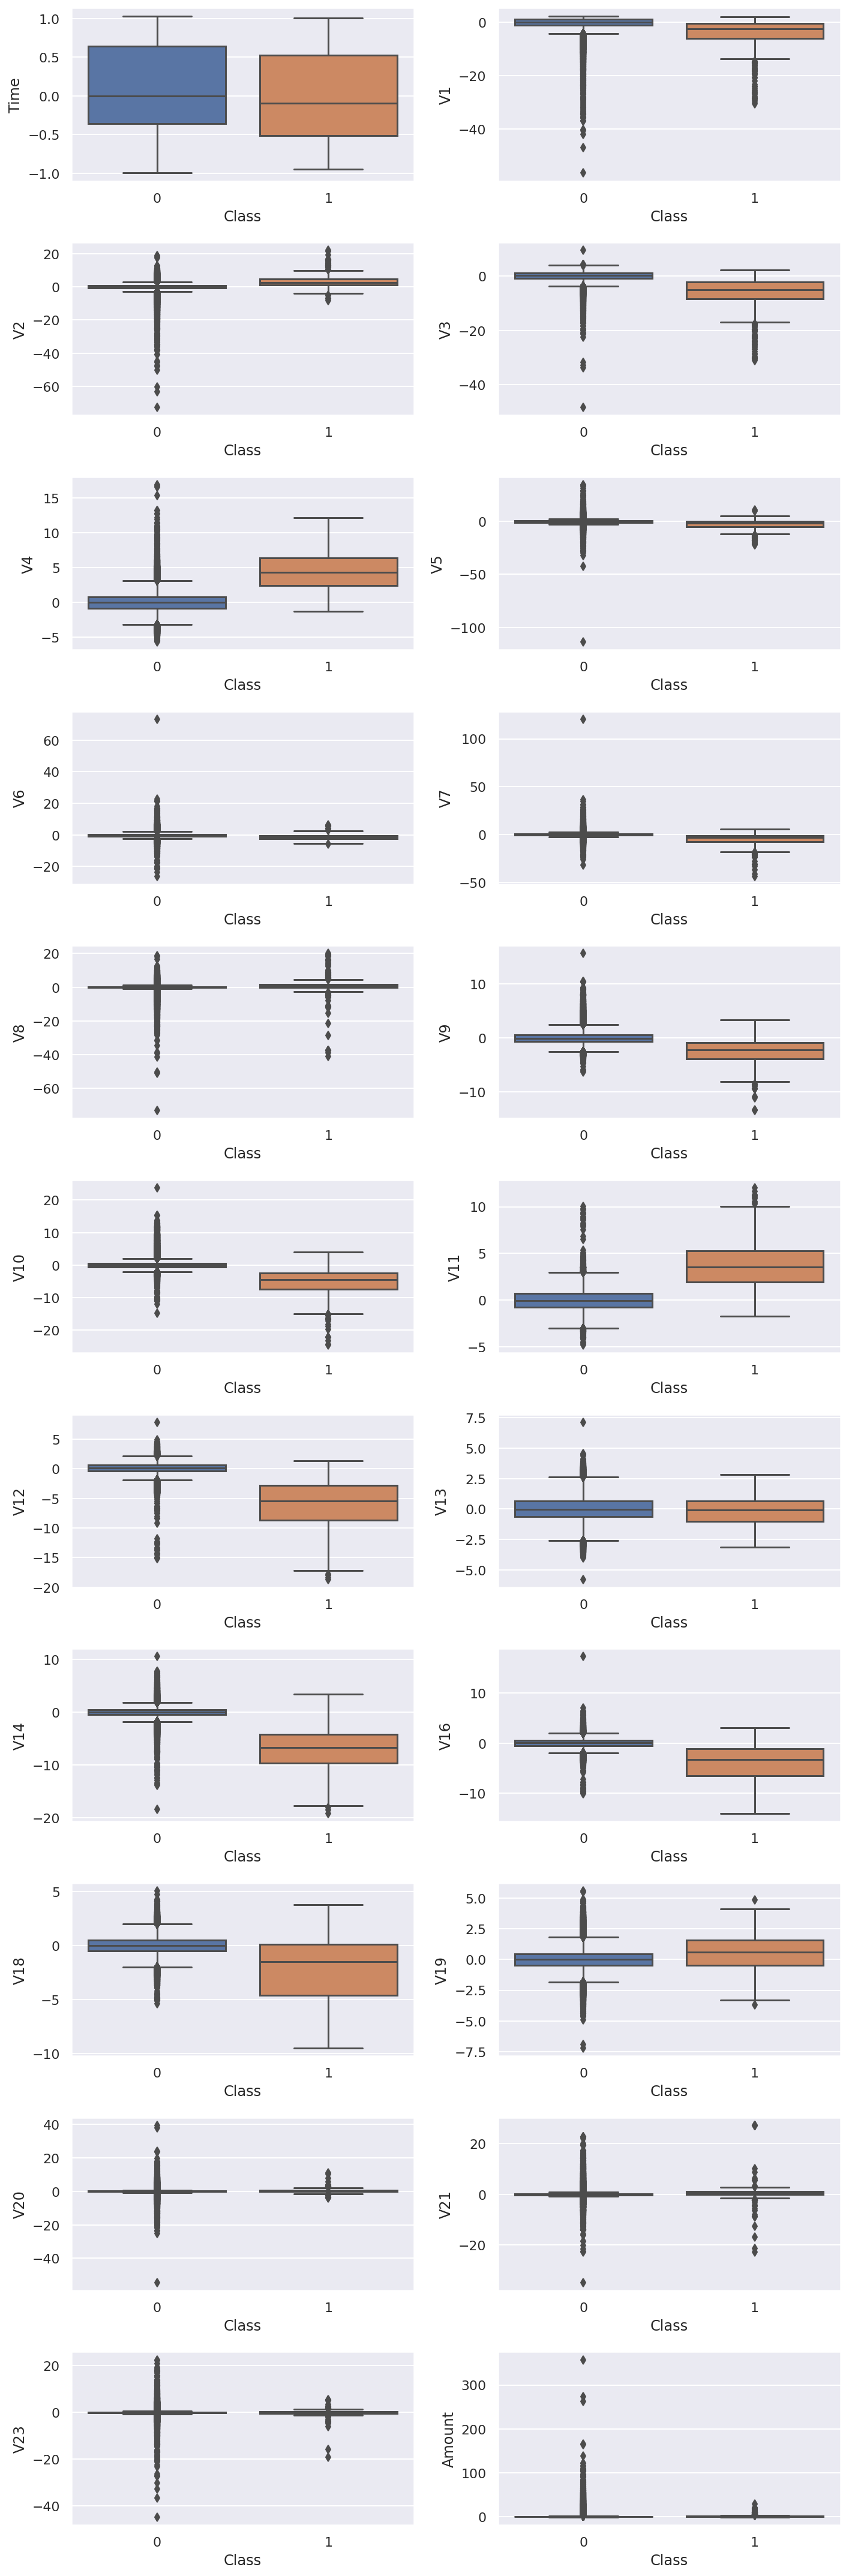

In [ ]:
rows = 11
cols = 2
index = 0
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 30))
columns = X_train.columns[X_train.columns != "Class"]
for i in range(rows):
    for j in range(cols):
        sns.boxplot(data.Class, columns[index], data=X_train, ax=ax[i, j])
        index = index + 1

plt.tight_layout()

# **Sampling Techniques for Imbalance Data.**

> [**imbalanced-learn documentation**](https://imbalanced-learn.org/stable/index.html#)

> [**imbalanced-learn API reference**](https://imbalanced-learn.org/stable/references/index.html#api)

There are two types of resampling methods to deal with imbalanced data, i.e., **Under-sampling** and **Over-sampling**.

*   **Under-sampling**: Take random draws from non-fraud observations to match the number of fraud observations. But we're randomly throwing away a lot of data and information. This technique is known as Random Under-Sampling.

*   **Over-sampling**: Take random draws from fraud cases and copy these observations to increase the number of fraud samples in the dataset. But we are going to train our model on several duplicates. This technique is known as Random Over-Sampling.

*   **Synthetic Minority Oversampling Technique (SMOTE)**: Adjust the data imbalance by over-sampling the minority observations (fraud cases) using nearest neighbors of fraud cases to create new synthetic fraud cases instead of just coping minority samples.

*There is a common mistake while performing resampling, i.e., testing our model on the oversampled or undersampled dataset. If we want to implement cross-validation, then always split the dataset into training and validation sets before over-sampling or under-sampling the records and then just oversample or undersample the training record. Another way to avoid this is to use the [**Pipeline**](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html) method.*

## **Random Under-Sampling**

***Random Under-sampling involves randomly selecting examples from the majority class and deleting them from the training dataset. In random under-sampling, the majority of class instances are discarded at random until a more balanced distribution is reached.***

> [**NearMiss**](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.NearMiss.html)

### **Steps:**

1.  The first thing is to determine how **imbalanced** is the class labels (use "**value_counts()**" on the class column to determine the amount for each class label).

2.  After determining how many instances are considered **fraud transactions**, we should bring the **non-fraud transactions** to the same level as **fraud transactions** (assuming we want a 50/50 ratio). It will be equivalent to 492 cases of **fraud** and 492 cases of **non-fraud** transactions.

3.  After implementing this technique, we have a sub-sample of the data frame with a 50/50 ratio for each class. Then the next step is to **shuffle the data** to see if our models can maintain a certain accuracy every time we run this script.

The main issue with **"Random Under-sampling"** is that the classification models will not perform as accurately as we would like to since there is a **great deal of information loss** (i.e., bringing 492 non-fraud transactions from 284,315 non-fraud transactions).


In [ ]:
# Implement Under-sampling for Handling Imbalanced.
from imblearn.under_sampling import NearMiss

nm = NearMiss()
X_undersample, y_undersample = nm.fit_resample(X, y)

In [ ]:
print(X_undersample.shape, y_undersample.shape)

(984, 22) (984,)


In [ ]:
from collections import Counter

print("Original Label Count {}".format(Counter(y)))
print("Resampled Label Count {}".format(Counter(y_undersample)))

Original Label Count Counter({0: 284315, 1: 492})
Resampled Label Count Counter({0: 492, 1: 492})


In [ ]:
# Randomly Shuffle data and target variables.
from sklearn.utils import shuffle

X_undersample, y_undersample = shuffle(X_undersample, y_undersample)

## **Over-Sampling Methods**

> [**imbalanced-learn API reference**](https://imbalanced-learn.org/stable/references/index.html#api)

1. **Random Over-Sampling**

2. **SMOTE Algorithms**

## **Random Over-Sampling**

> [**RandomOverSampler**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler)

***Random Over-sampling involves randomly selecting examples from the minority class with replacements, and adding them to the training dataset. In the random over-sampling, the minority class instances are selected with replacement until a more balanced distribution is reached.***

In [ ]:
# Implement Over-sampling for Handling Imbalanced Dataset.
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_oversample, y_oversample = ros.fit_resample(X, y)

In [ ]:
print(X_oversample.shape, y_oversample.shape)

(568630, 22) (568630,)


In [ ]:
from collections import Counter

print("Original Label Count {}".format(Counter(y)))
print("Resampled Label Count {}".format(Counter(y_oversample)))

Original Label Count Counter({0: 284315, 1: 492})
Resampled Label Count Counter({0: 284315, 1: 284315})


In [ ]:
# Randomly Shuffle data and target variables.
from sklearn.utils import shuffle

X_oversample, y_oversample = shuffle(X_oversample, y_oversample)

## **SMOTE Algorithm**

> [**SMOTE algorithms**](https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms)

> [**class imblearn.over_sampling.SMOTE()**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE)

***SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.***

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**
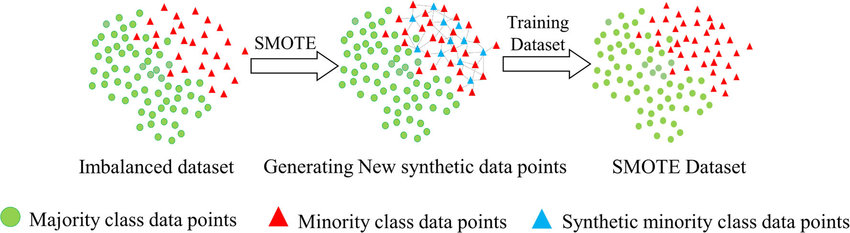

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

***SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random Under-sampling, SMOTE creates new synthetic points to have an equal balance of the classes. This technique is another alternative for solving the "class imbalance problems".***

### **Understanding SMOTE:**

*   **Solving the Class Imbalance:** SMOTE creates synthetic data points from the minority class to reach an equal balance between the minority and majority class.

*   **Location of the Synthetic Points:** SMOTE picks the distance between the closest neighbors of the minority class. In between these distances, it creates synthetic data points.

*   **Final Effect:** More information is retained, since we didn't have to delete any rows unlike in random under-sampling.

*   **Accuracy || Time Tradeoff:** Although SMOTE will likely be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [ ]:
# Implement SMOTE Sampling for Handling Imbalanced Dataset.
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
print(X_smote.shape, y_smote.shape)

(568630, 22) (568630,)


In [ ]:
from collections import Counter

print("Original Label Count {}".format(Counter(y)))
print("Resampled Label Count {}".format(Counter(y_smote)))

Original Label Count Counter({0: 284315, 1: 492})
Resampled Label Count Counter({0: 284315, 1: 284315})


In [ ]:
# Randomly Shuffle data and target variables.
from sklearn.utils import shuffle

X_smote, y_smote = shuffle(X_smote, y_smote)

## **Combination of Over- and Under-sampling Methods**

> The [**imblearn.combine**](https://imbalanced-learn.org/stable/references/combine.html) provides methods which combine over-sampling and under-sampling.

> [**class imblearn.combine.SMOTETomek()**](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [ ]:
# Implement SMOTETomek Sampling for Handling Imbalanced Dataset.
from imblearn.combine import SMOTETomek

tomek = SMOTETomek(random_state=42)
X_tomek, y_tomek = tomek.fit_resample(X, y)

In [ ]:
print(X_tomek.shape, y_tomek.shape)

(567398, 22) (567398,)


In [ ]:
from collections import Counter

print("Original Label Count {}".format(Counter(y)))
print("Resampled Label Count {}".format(Counter(y_tomek)))

Original Label Count Counter({0: 284315, 1: 492})
Resampled Label Count Counter({0: 283699, 1: 283699})


In [ ]:
# Randomly Shuffle data and target variables.
from sklearn.utils import shuffle

X_tomek, y_tomek = shuffle(X_tomek, y_tomek)

## **Overfitting during Cross-Validation.**

It is not advisable to undersample or oversample the dataset before cross-validation. It is because we will be directly influencing the validation set before implementing cross-validation, causing a "data leakage" problem.


### **The Wrong Way:**

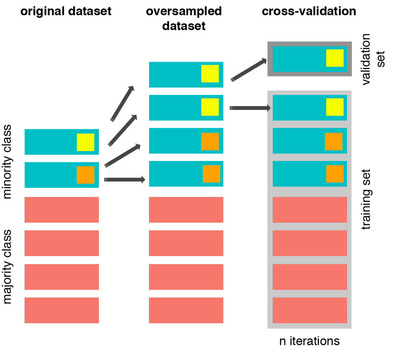


As mentioned previously, if we get the minority class **"Fraud"**, then, in that case, creating the synthetic points before cross-validating will have a certain influence on the "validation set" in the cross-validation process. Recall how cross-validation works: let's assume we are splitting the dataset into 5 batches, where 4/5 of the dataset will be the training set while 1/5 will be the validation set. **The test set should be untouched.** For that reason, we have to do the creation of synthetic data points "during" cross-validation and not before, just like below:


### **The Right Way:**

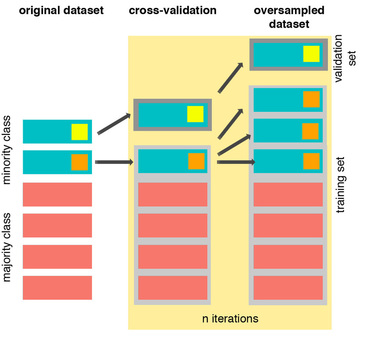


As we see above, SMOTE occurs **"during"** cross-validation and **"not prior"** to the cross-validation process. Synthetic data are created only for the training set without affecting the validation set.

>  [**DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION**](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation)

>  [**Overcoming Class Imbalance using SMOTE Techniques**](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/)